In [24]:
%load_ext autoreload
%autoreload 1
%matplotlib inline
# %aimport utils.remote_execute_util
import os
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import scikitplot as skplt
import joblib
from dotenv import load_dotenv
from azureml.core import Experiment
from azureml.train.estimator import Estimator
from azureml.widgets import RunDetails
from amlutils import aml_util as a_util
from amlutils import blobs_util as b_util
import mnist_util as m_util
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

# Image Classification Model based on MNIST dataset
## Remote Training in the Azure ML Workspace
Based on Azure official tutorial https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-train-models-with-aml. See also:

https://github.com/Azure/MachineLearningNotebooks/tree/master/tutorials
https://github.com/piizei/mlops.git

We assume the training data is available in a blob storage container with name 'mnist'

### Prepare Workspace
Make sure you have downloaded config.json from your azure ml workspace into the project root. Additionally, you might need to put

    TENANT=<YOUR TENANT ID>

in .env in the project root, along with the access credentials to the blob storage account with the training data as described in the notebook for local training.
    
Get a reference to the workspace instance:

In [4]:
ws = a_util.get_ws()

We need to make sure the blob storage container with the training data is registered as a datastore in the workspace:

In [8]:
for name, ds in ws.datastores.items():
    print(name)

workspaceblobstore
workspacefilestore
dsmnist


In [9]:
try:
    ds = b_util.get_ds(ws, 'dsmnist')
except Exception:
    ds = b_util.register_blob_ws(ws, 'dsmnist', 'mnist')

Start up a compute cluster in the workspace. If you select minimum number of nodes = 0 it will automatically scale down to 0 after each job and not incurr any cost. Note however, provisioning nodes takes a couple of minutes each time.

In [ ]:
# instanciate the remote compute
compute_target = a_util.prepare_remote_compute(ws, compute_name='cpucluster', compute_min_nodes=0, compute_max_nodes=1, compute_vm_size='STANDARD_D2_V2')

### Setup the experiment
The configuration of the experiment:

In [11]:
#Define the folder that is sent to remote computing
script_folder  = os.getcwd()

#An estimator object is used to submit the run.
script_params = {
    '--data-folder': ds.as_mount(), # .path('mnist')
    '--regularization': 0.01
}

estimator = Estimator(source_directory=script_folder,
                      script_params=script_params,
                      compute_target=compute_target,
                      entry_script='mnist_train.py',
                      pip_requirements_file='requirements_remote.txt' # we don't need all the packages from local run
                     )

### Run the experiment
and watch the progress of the run with a Jupyter widget:

In [ ]:
experiment = Experiment(workspace=ws, name='expmnist')
run = experiment.submit(config=estimator)
run

In [ ]:
# this does not work in Jupyter Lab
RunDetails(run).show()

In [ ]:
run.wait_for_completion(show_output=False)  # specify True for a verbose log

### Display run results

In [25]:
print(run.get_metrics())

{'regularization rate': 0.01, 'accuracy': 0.9257}


### Register the model
The last step in the training script wrote the file outputs/sklearn_mnist_model.pkl in a directory named outputs in the VM of the cluster where the job is run. outputs is a special directory in that all content in this directory is automatically uploaded to your workspace. This content appears in the run record in the experiment under your workspace. So the model file is now also available in your workspace.

Register the model in the workspace, so that you or other collaborators can later query, examine, and deploy this model. You can also compare with other registered models so far and, for example, only register when the new one is more accurate etc. 

In [18]:
# models = Model.list(workspace=ws, name=model_name)
model = run.register_model(model_name='sklearn_mnist',
                           model_path='outputs/sklearn_mnist_model.pkl')
print(model.name, model.id, model.version, sep='\t')

sklearn_mnist	sklearn_mnist:1	1


### Delete compute ressources

In [52]:
# optionally, delete the Azure Machine Learning Compute cluster
compute_target.delete()

## Download the trained model and predict locally

In [ ]:
# model = Model(ws, 'sklearn_mnist')
output_folder = os.getenv('OUTPUT_REMOTE')
os.makedirs(output_folder, exist_ok=True)
model.download(target_dir=output_folder, exist_ok=True)

In [ ]:
clf = joblib.load(os.path.join(output_folder, 'sklearn_mnist_model.pkl'))

In [21]:
data_folder = os.getenv('DATA_LOCAL')
X_test = m_util.load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_test = m_util.load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)
y_hat = clf.predict(X_test)

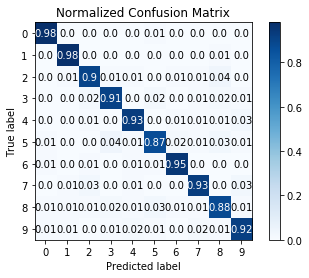

In [25]:
skplt.metrics.plot_confusion_matrix(y_test, y_hat, normalize=True)
plt.show()

In [26]:
print('Overall accuracy:', np.average(y_hat == y_test))

Overall accuracy: 0.9257
